In [7]:


import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta, AutoNormal
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Trace_ELBO
import torch

import seaborn as sns
import matplotlib.pyplot as plt



# Model

Below is a simple 1D gaussian mixture model with component specific means and global variance parameters.  We have used the @config_enumerate decorator to tell pyro to enumerate over, or marginalize, the discrete random variables (assignment).


In [8]:

K = 2

@config_enumerate
def model(data=None, n_data=None):
    assert (data is None) != (n_data is None)
    if n_data is None:
        n_data = data.shape[0]

    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 0.5))

    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 4.))

    with pyro.plate('data', n_data):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)



# Simulate data

Generate 100 data points from the model.  Print the simulated parameters and show a histogram of the simulated data.


weights [0.917575   0.08242498]
scale 0.3148601
locs [6.5407276 8.245778 ]


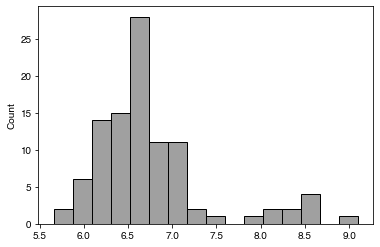

In [9]:

pyro.set_rng_seed(2022)
pyro.clear_param_store()

model_trace = pyro.poutine.trace(model)

samples = model_trace.get_trace(n_data=100)

for a in ('weights', 'scale', 'locs'):
    print(a, samples.nodes[a]['value'].detach().numpy())

sns.histplot(x=samples.nodes['obs']['value'].detach().numpy(), color='0.5')

data = samples.nodes['obs']['value'].detach()



# Inference

Use the TraceEnum_ELBO implementation of the elbo calculation that enumerates and marginalizes over the discrete hidden variables.  Use the AutoDelta guide for the remaining variables, which will use a delta function to approximate the posteriors of hidden variables producing point estimates of each variable.


In [10]:

optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

pyro.set_rng_seed(1)
pyro.clear_param_store()

global_guide = AutoDelta(
    pyro.poutine.block(model, expose=['weights', 'locs', 'scale']))

svi = SVI(model, global_guide, optim, loss=elbo)



...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

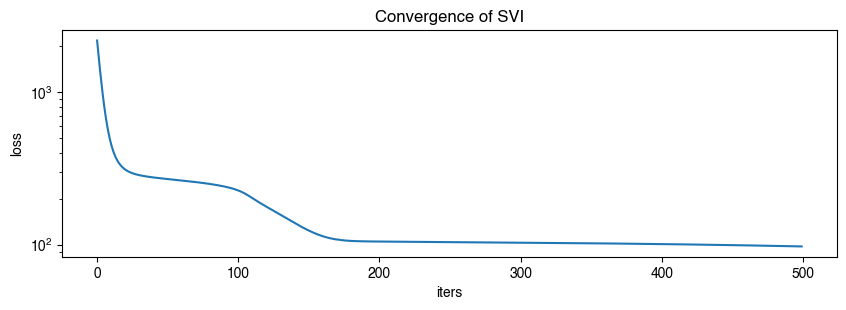

In [11]:

losses = []
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');


In [12]:

for k in pyro.get_param_store():
    print(k, pyro.get_param_store()[k].detach())


AutoDelta.weights tensor([1.0000e+00, 1.3988e-09])
AutoDelta.scale tensor(0.6579)
AutoDelta.locs tensor([6.7522, 4.4876])



# Additional exercises

1. The inferred parameters were innaccurate, try generating a better initialization as described in the [gmm tutorial](https://pyro.ai/examples/gmm.html#Training-a-MAP-estimator)
2. Extend the GMM to a 2D model
3. Modify from global variance to component specific variance
4. Modify from global variance to dimension specific variance



# Answer key from here:


In [5]:

def init_loc_fn(site):
    if site["name"] == "weights":
        # Initialize weights to uniform.
        return torch.ones(K) / K
    if site["name"] == "scale":
        return (data.var() / 2).sqrt()
    if site["name"] == "locs":
        return data[torch.multinomial(torch.ones(len(data)) / len(data), K)]
    raise ValueError(site["name"])

def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(
        pyro.poutine.block(model, expose=['weights', 'locs', 'scale']),
        init_loc_fn=init_loc_fn)
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, data)

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))


seed = 98, initial_loss = 117.02839660644531


In [6]:

losses = []
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')



...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

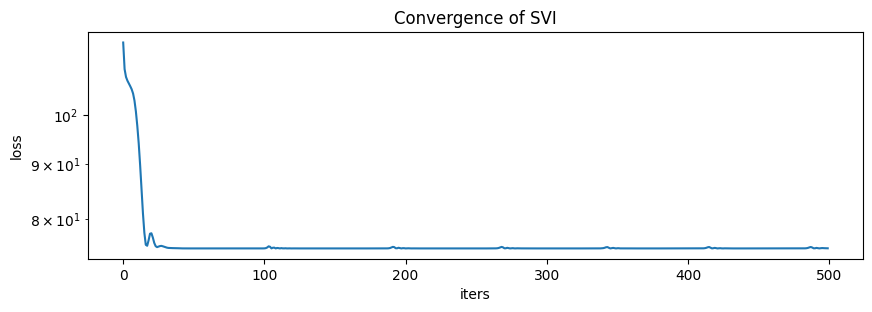

In [7]:

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');


In [8]:

for k in pyro.get_param_store():
    print(k, pyro.get_param_store()[k].detach())


AutoDelta.weights tensor([0.9042, 0.0958])
AutoDelta.scale tensor(0.3434)
AutoDelta.locs tensor([6.5672, 8.4262])



# 2D GMM


In [249]:

K = 3
D = 2

@config_enumerate
def model(data=None, n_data=None):
    assert (data is None) != (n_data is None)
    if n_data is None:
        n_data = data.shape[0]

    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))

    scale = pyro.sample('scale', dist.LogNormal(0., 0.5))

    with pyro.plate('dims', D):
        with pyro.plate('components', K):
            locs = pyro.sample('locs', dist.Normal(0., 4.))

    with pyro.plate('data', n_data):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        obs = pyro.sample('obs', dist.Normal(locs[assignment], scale).to_event(1), obs=data)


In [176]:

trace = poutine.trace(model).get_trace(n_data=11)
trace.compute_log_prob()
print(trace.format_shapes())


  Trace Shapes:         
   Param Sites:         
  Sample Sites:         
   weights dist      | 3
          value      | 3
       log_prob      |  
     scale dist      |  
          value      |  
       log_prob      |  
      dims dist      |  
          value    2 |  
       log_prob      |  
components dist      |  
          value    3 |  
       log_prob      |  
      locs dist 3  2 |  
          value 3  2 |  
       log_prob 3  2 |  
      data dist      |  
          value   11 |  
       log_prob      |  
assignment dist   11 |  
          value   11 |  
       log_prob   11 |  
       obs dist   11 | 2
          value   11 | 2
       log_prob   11 |  



# 2D GMM with component specific variance


In [390]:

K = 3
D = 2

@config_enumerate
def model(data=None, n_data=None):
    assert (data is None) != (n_data is None)
    if n_data is None:
        n_data = data.shape[0]

    weights = pyro.sample('weights', dist.Dirichlet(1. * torch.ones(K)))

    dims = pyro.plate('dims', D, dim=-1)
    components = pyro.plate('components', K, dim=-2)

    with components:
        scale = pyro.sample('scale', dist.LogNormal(0., 0.5))

    with dims:
        with components:
            locs = pyro.sample('locs', dist.Normal(0., 4.))

    with pyro.plate('data', n_data):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        obs = pyro.sample('obs', dist.Normal(locs[assignment], scale[assignment]).to_event(1), obs=data)



# 2D GMM with component specific variance (alternate)


In [391]:

K = 3
D = 2

@config_enumerate
def model(data=None, n_data=None):
    assert (data is None) != (n_data is None)
    if n_data is None:
        n_data = data.shape[0]

    weights = pyro.sample('weights', dist.Dirichlet(1. * torch.ones(K)))

    dims = pyro.plate('dims', D, dim=-2)
    components = pyro.plate('components', K, dim=-1)

    with components:
        scale = pyro.sample('scale', dist.LogNormal(0., 0.5))
        with dims:
            locs = pyro.sample('locs', dist.Normal(0., 4.))

    with pyro.plate('data', n_data):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        obs = pyro.sample('obs', dist.Normal(locs.swapaxes(-1, -2)[assignment], scale[assignment, None]).to_event(1), obs=data)



# 2D GMM with dimension specific variance


In [392]:

K = 3
D = 2

@config_enumerate
def model(data=None, n_data=None):
    assert (data is None) != (n_data is None)
    if n_data is None:
        n_data = data.shape[0]

    weights = pyro.sample('weights', dist.Dirichlet(1. * torch.ones(K)))

    dims = pyro.plate('dims', D, dim=-2)
    components = pyro.plate('components', K, dim=-1)

    with dims:
        scale = pyro.sample('scale', dist.LogNormal(0., 0.5))

    with components:
        with dims:
            locs = pyro.sample('locs', dist.Normal(0., 4.))

    with pyro.plate('data', n_data):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        obs = pyro.sample('obs', dist.Normal(locs.swapaxes(-1, -2)[assignment], scale.swapaxes(-1, -2)).to_event(1), obs=data)


In [393]:

trace = poutine.trace(model).get_trace(n_data=11)
trace.compute_log_prob()
print(trace.format_shapes())


  Trace Shapes:         
   Param Sites:         
  Sample Sites:         
   weights dist      | 3
          value      | 3
       log_prob      |  
      dims dist      |  
          value    2 |  
       log_prob      |  
components dist      |  
          value    3 |  
       log_prob      |  
     scale dist 2  1 |  
          value 2  1 |  
       log_prob 2  1 |  
      locs dist 2  3 |  
          value 2  3 |  
       log_prob 2  3 |  
      data dist      |  
          value   11 |  
       log_prob      |  
assignment dist   11 |  
          value   11 |  
       log_prob   11 |  
       obs dist   11 | 2
          value   11 | 2
       log_prob   11 |  


In [394]:

trace = poutine.trace(poutine.enum(model, first_available_dim=-2)).get_trace(n_data=11)
trace.compute_log_prob()
print(trace.format_shapes())


  Trace Shapes:         
   Param Sites:         
  Sample Sites:         
   weights dist      | 3
          value      | 3
       log_prob      |  
      dims dist      |  
          value    2 |  
       log_prob      |  
components dist      |  
          value    3 |  
       log_prob      |  
     scale dist 2  1 |  
          value 2  1 |  
       log_prob 2  1 |  
      locs dist 2  3 |  
          value 2  3 |  
       log_prob 2  3 |  
      data dist      |  
          value   11 |  
       log_prob      |  
assignment dist   11 |  
          value 3  1 |  
       log_prob 3 11 |  
       obs dist 3 11 | 2
          value 3 11 | 2
       log_prob 3 11 |  


weights [0.1299249  0.64615023 0.22392489]
scale [[0.6280262]
 [1.3850185]]
locs [[ 0.5290737 -4.0344687  4.0141873]
 [-1.8481947 -3.6609821  1.4186052]]


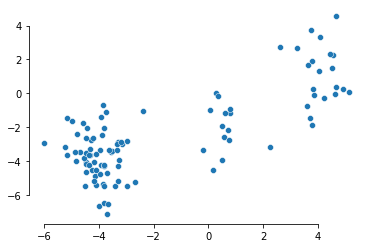

In [420]:

pyro.set_rng_seed(59)
pyro.clear_param_store()

model_trace = pyro.poutine.trace(model)

samples = model_trace.get_trace(n_data=100)

for a in ('weights', 'scale', 'locs'):
    print(a, samples.nodes[a]['value'].detach().numpy())

data = samples.nodes['obs']['value'].detach()

sns.scatterplot(x=data[:, 0], y=data[:, 1])
sns.despine(trim=True)


In [421]:

optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)

pyro.set_rng_seed(1)
pyro.clear_param_store()

global_guide = AutoDelta(
    pyro.poutine.block(model, expose=['weights', 'locs', 'scale']))

svi = SVI(model, global_guide, optim, loss=elbo)

losses = []
for i in range(100):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')



...................................................................................................

In [422]:

for k in pyro.get_param_store():
    print(k, pyro.get_param_store()[k].detach())


AutoDelta.weights tensor([0.6538, 0.2034, 0.1428])
AutoDelta.scale tensor([[1.2419],
        [1.4078]])
AutoDelta.locs tensor([[-3.6210,  4.0619,  0.8939],
        [-3.7562,  1.2663, -1.9768]])
